In [52]:
import pandas as pd
import altair as alt
from vega_datasets import data as vega_data

# Load cleaned data
df = pd.read_csv("../data/data_science_job_posts_2025_clean.csv", low_memory=False)

alt.data_transformers.disable_max_rows()
alt.renderers.enable('svg')

RendererRegistry.enable('svg')

# Linked view Visualization 1 - Top Skill Demand x Salary Distribution

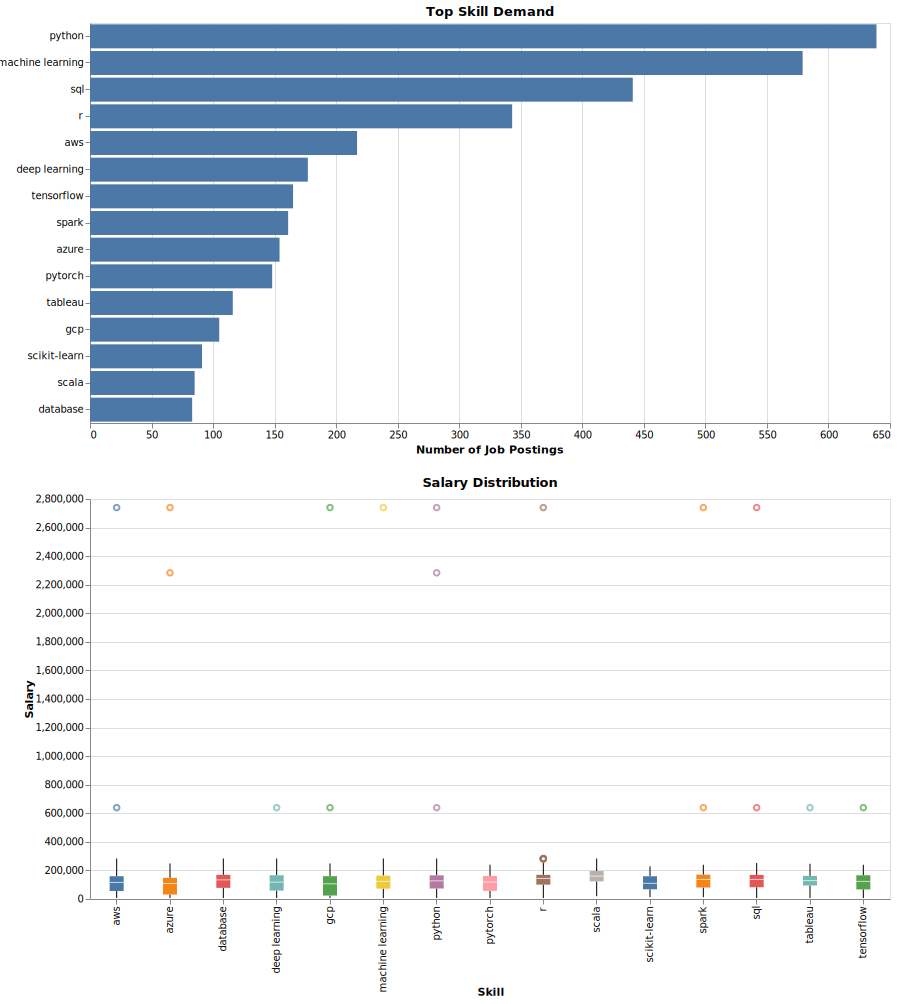

In [53]:
# explode skills column
skills_long = (
    df.assign(skill=df["skills_clean"].fillna("").apply(lambda s: [x for x in s.split("|") if x]))
      .explode("skill")
)

skill_counts = (
    skills_long["skill"]
    .value_counts()
    .rename_axis("skill")
    .reset_index(name="num_postings")
)

top_skills = skill_counts.head(15)["skill"].tolist()

# filter exploded data to just those top skills
skills_top = skills_long[skills_long["skill"].isin(top_skills)]
alt.data_transformers.disable_max_rows()
skill_select = alt.selection_point(fields=["skill"], name="SkillSelect", clear="true")

# View A: driver bar chart
bar = (
    alt.Chart(skill_counts.head(15), title="Top Skill Demand")
      .mark_bar()
      .encode(
          y=alt.Y("skill:N", sort="-x", title=None),
          x=alt.X("num_postings:Q", title="Number of Job Postings"),
          tooltip=["skill:N", "num_postings:Q"]
      )
      .add_params(skill_select)
      .properties(width=800, height=400)
)

# View B: linked salary distribution
box = (
    alt.Chart(skills_top, title="Salary Distribution")
      .transform_filter(skill_select)
      .mark_boxplot()
      .encode(
          x=alt.X("skill:N", title="Skill"),
          y=alt.Y("salary_mid:Q", title="Salary"),
          color=alt.Color("skill:N", legend=None),
          tooltip=["skill:N", alt.Tooltip("salary_mid:Q", title="Salary")]
      )
      .properties(width=800, height=400)
)

chart = alt.vconcat(bar, box)
chart


# Linked view Visualization 2 - Median salary x Top Industries

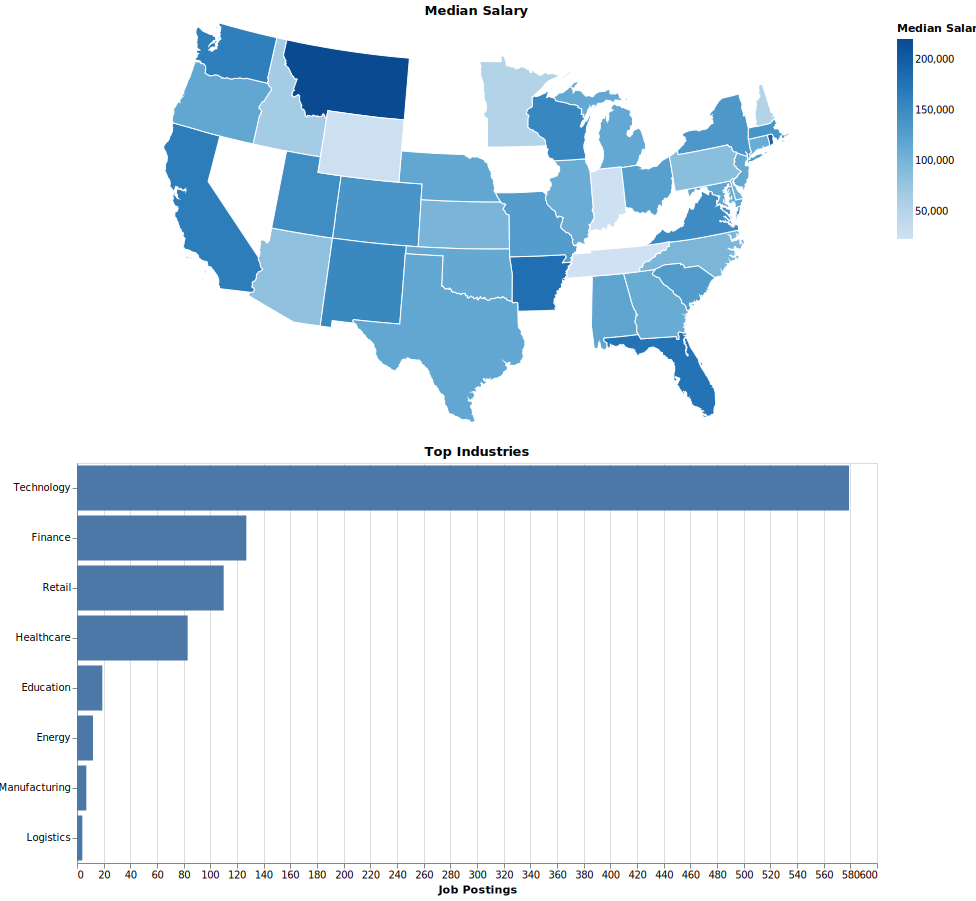

In [54]:
# aggregate - median salary + job count per state
state_agg = (
    df.groupby(["state", "fips_int"], as_index=False)
            .agg(
                median_salary=("salary_mid", "median"),
                n_jobs=("state", "size")
            )
)

# load US states topojson
us_states = alt.topo_feature(vega_data.us_10m.url, "states")
alt.data_transformers.disable_max_rows()
state_select = alt.selection_point(fields=["fips_int"], name="StateSelect")

# View A: driver choropleth
map_chart = (
    alt.Chart(us_states, title="Median Salary")
      .mark_geoshape(stroke="white")
      .encode(
          color=alt.Color(
              "median_salary:Q",
              title="Median Salary",
              scale=alt.Scale(scheme="blues")
          ),
          tooltip=[
              alt.Tooltip("state:N", title="State"),
              alt.Tooltip("median_salary:Q", title="Median Salary"),
              alt.Tooltip("n_jobs:Q", title="# Jobs")
          ]
      )
      .transform_lookup(
          lookup="id",
          from_=alt.LookupData(
              state_agg,
              key="fips_int",
              fields=["state", "median_salary", "n_jobs", "fips_int"]
          )
      )
      .add_params(state_select)
      .project(type="albersUsa")
      .properties(width=800, height=400)
)

# View B: linked industries bar chart (only for selected state)
industries = (
    alt.Chart(df, title="Top Industries")
      .transform_filter(state_select)
      .mark_bar()
      .encode(
          x=alt.X("count():Q", title="Job Postings"),
          y=alt.Y("industry:N", sort="-x", title=None),
          tooltip=[
              "industry:N",
              alt.Tooltip("count():Q", title="# Jobs in State")
          ]
      )
      .properties(width=800, height=400)
)

chart = alt.vconcat(map_chart, industries)
chart
